In [ ]:
#import py7zr
import pandas as pd

import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt

import shutil
import os

# IMC dataset from https://bodenmillergroup.github.io/imcdatasets/reference/Damond_2019_Pancreas.html
# archive_path = "6089.7z"
# output_dir = "6089"

# with py7zr.SevenZipFile(archive_path, mode='r') as z:
#     z.extractall(path=output_dir)



membrane_targets = [
    "CD38", "CD44", "CD99", "CD68", "CD20", "CD3 epsilon",
    "CD279 (PD-1)", "Cytokeratin 19", "CD45", "CD45RA",
    "CD8a", "CD4", "CD31", "E-Cadherin / P-Cadherin"
]



# Load panel only once
panel_df = pd.read_csv("Panel.csv")
panel_df_clean = panel_df.dropna(subset=["MetalTag"])
panel_df_clean = panel_df_clean[panel_df_clean["MetalTag"] != "NA"]
panel_dict = dict(zip(panel_df_clean["MetalTag"], panel_df_clean["Target"]))

input_folder = "./6089/"
mask_folder = "./Masks/"
output_root = "./Damond/test_6089_2_channel/"

output_nuclear_folder = os.path.join(output_root, "images/nuclear")
output_full_folder = os.path.join(output_root, "images/whole_cell")
output_mask_folder = os.path.join(output_root, "masks/whole_cell")

# Create new directory structure
os.makedirs(output_nuclear_folder, exist_ok=True)
os.makedirs(output_full_folder, exist_ok=True)
os.makedirs(output_mask_folder, exist_ok=True)


# Loop through all tiffs in 6089 folder
for fname in os.listdir(input_folder):
    if not fname.endswith(".tiff") and not fname.endswith(".tif"):
        continue

    base = fname.replace(".tiff", "").replace(".tif", "")
    print(f"Processing: {base}")

    # Load TIFF image
    img_path = os.path.join(input_folder, fname)
    img = tiff.imread(img_path)

    # Load channel CSV for this file
    csv_path = os.path.join(input_folder, f"{base}.csv")
    channels_df = pd.read_csv(csv_path)

    # Extract channel names (MetalTag)
    channel_names = np.array(channels_df.columns).tolist()
    channel_other_names = np.array(channels_df).tolist()
    channel_remain_names = [item[0] for item in channel_other_names]
    channel_names.extend(channel_remain_names)

    # Filter panel dictionary to only include these 37 channels
    panel_filtered = {tag: panel_dict.get(tag) for tag in channel_names}

    # Build membrane channel indices
    membrane_indices = [
        i for i, metal in enumerate(channel_names)
        if panel_filtered[metal] in membrane_targets
    ]

    # Extract nuclear channels: Ir191 + Ir193
    ir191_idx = channel_names.index("Ir191")
    ir193_idx = channel_names.index("Ir193")

    nuc = img[ir191_idx].astype(float) + img[ir193_idx].astype(float)
    nuc_norm = (nuc - nuc.min()) / (nuc.max() - nuc.min())

    # Save nuclear only version
    nuc_out = (nuc_norm * 255).astype("uint8")
    nuclear_out_path = os.path.join(output_nuclear_folder, f"{base}.tif")
    tiff.imwrite(nuclear_out_path, nuc_out)

    # Build membrane composite
    membrane = img[membrane_indices].mean(axis=0)
    membrane_norm = (membrane - membrane.min()) / (membrane.max() - membrane.min())

    # # Build RGB for Cellpose: R=0, G=nuclear, B=membrane
    rgb = np.dstack([
        np.zeros_like(nuc_norm),
        nuc_norm,
        membrane_norm
    ])

    # Save Cellpose-ready image
    rgb_out = (rgb * 255).astype("uint8")
    full_out_path = os.path.join(output_full_folder, f"{base}.tif")
    tiff.imwrite(full_out_path, rgb_out)

    # Copy mask from Masks/ folder to output folder
    mask_src = os.path.join(mask_folder, f"{base}_mask.tiff")
    if os.path.exists(mask_src):
        mask_dst = os.path.join(output_mask_folder, f"{base}_mask.tif")
        shutil.copy(mask_src, mask_dst)
        print(f"Copied mask: {mask_src} → {mask_dst}")
    else:
        print(f"Mask not found for {base}")
        

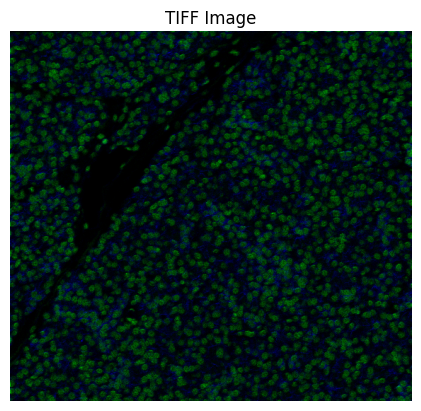

In [5]:
import tifffile as tiff
import matplotlib.pyplot as plt

img = tiff.imread("./Damond/test_6089/images/P05_a0_full.tif")

plt.imshow(img)
plt.title("TIFF Image")
plt.axis("off")
plt.show()

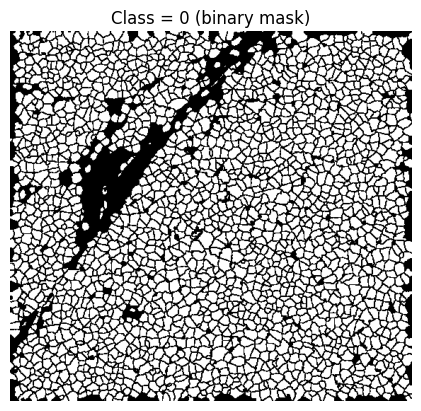

In [36]:
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np

img = tiff.imread("./Masks/P05_a0_full_mask.tiff")

class1 = (img>0)

plt.imshow(class1, cmap="gray")
plt.title("mask")
plt.axis("off")
plt.show()